# Import Necessary Library

In [ ]:
!pip install xgboost lightgbm catboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 1. Data Acquisition

In [3]:
df = pd.read_csv("duplicate_questions_pairs.xls")

In [4]:
# Display First 5 rows of the dataset
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
# Shape of the dataset
df.shape

(404290, 6)

In [6]:
# Check Dtype and Non-Null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
# Check Missing Values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
# Check Duplicated Values
df.duplicated().sum()

0

0    255027
1    149263
Name: is_duplicate, dtype: int64
0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


<Axes: >

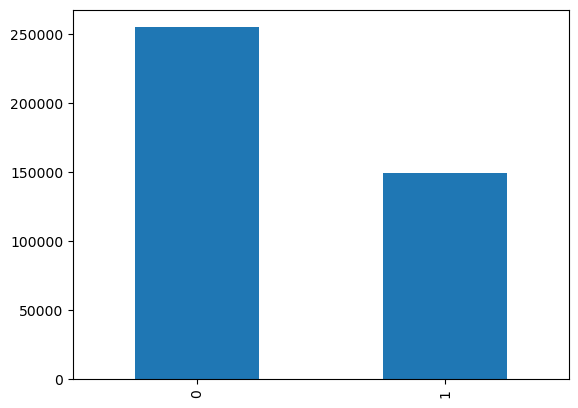

In [9]:
# Distribution of duplicate and non-duplicate questions

print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [10]:
# Combine both question IDs into a single list
all_qids = df['qid1'].tolist() + df['qid2'].tolist()

# Convert list into a pandas Series
qid_series = pd.Series(all_qids)

# Total unique questions
unique_questions = qid_series.nunique()
print("Total unique questions:", unique_questions)

#  Repeated Question
repeated_questions = (qid_series.value_counts() > 1).sum()
print("Number of questions getting repeated:", repeated_questions)

Total unique questions: 537933
Number of questions getting repeated: 111780


In [11]:
# Drop rows with missing questions
df.dropna(subset=['question1', 'question2'], inplace=True)

In [12]:
# Now, again I am checking Missing Values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

# 2.Text Preprocessing

# Basic Preprocessing

In [13]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.corpus import stopwords
import string

In [14]:
print(df['question1'][0])
print(df['question2'][0])

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?


In [15]:
# Apply lowercase transformation to the 'Job Description' column

def clean_text(text):
    text = text.lower()    
    return text

In [16]:
# Apply cleaning to both questions
df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)

In [17]:
print(df['question1'][0])
print(df['question2'][0])

what is the step by step guide to invest in share market in india?
what is the step by step guide to invest in share market?


# Remove Punctuation

In [18]:
string.punctuation
punctuation = string.punctuation
exclude = punctuation

In [19]:
# Create a function 
def remove_punc(text):
    for char in exclude:
        text = text.replace(char,'')
    return text

In [20]:
# Apply remove_punc to both questions
df['question1'] = df['question1'].apply(remove_punc)
df['question2'] = df['question2'].apply(remove_punc)

In [21]:
# Here, we can see our punctuation has removed
df['question1'][0]

'what is the step by step guide to invest in share market in india'

# Stopwords Removing

In [22]:
english_stopwods = stopwords.words('english')
print(english_stopwods)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
def remove_stopwords(text):
    new_text = []
    
    for word in text.split():
        if word not in stopwords.words('english'):
            new_text.append(word)
            
    return " ".join(new_text)

In [24]:
df['question1'] = df['question1'].apply(remove_stopwords)
df['question2'] = df['question2'].apply(remove_stopwords)

# Word Tokenizations

In [25]:
def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

In [26]:
df['question1'] = df['question1'].apply(tokenization)
df['question2'] = df['question2'].apply(tokenization)

In [27]:
print(df['question1'][4222])
print(df['question2'][123])

['inside', 'bullet']
['greatest', 'mystery', 'time']


In [28]:
# X = Input Features
X = df['question1'].astype(str) + " " + df['question2'].astype(str)

# Target variable
y = df['is_duplicate']

# Text Vectorization

# Bag of word

In [29]:
cv = CountVectorizer()
X = cv.fit_transform(X)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# Split the dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size = 0.33,random_state = 42)

# Build the models

# Logistic Regression

In [32]:
lr = LogisticRegression()
lr

LogisticRegression()

In [33]:
# Train the model
lr.fit(X_train, y_train)
# Predict the model
lr_preds = lr.predict(X_test)
# Check the accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))

Logistic Regression Accuracy: 0.7503354195555222


# XGBClassifier 

In [34]:
xgb = XGBClassifier()
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [35]:
# Train the model
xgb.fit(X_train,y_train)
# Predict the model
y_pred = xgb.predict(X_test)
# Check Accuracy
print("XGB Classifier Accuracy",accuracy_score(y_test,y_pred))

XGB Classifier Accuracy 0.7358842708840835


# TF-IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
X = X = df['question1'].astype(str) + " " + df['question2'].astype(str)

# Step 3: TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

In [38]:
lr = LogisticRegression()
lr

LogisticRegression()

In [39]:
# Train the model
lr.fit(X_train, y_train)
# Predict the model
lr_preds = lr.predict(X_test)
# Check the accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))

Logistic Regression Accuracy: 0.7503354195555222


# XGB Classifier

In [40]:
xgb = XGBClassifier()
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [41]:
# Train the model
xgb.fit(X_train,y_train)
# Predict the model
y_pred = xgb.predict(X_test)
# Check Accuracy
print("XGB Classifier Accuracy",accuracy_score(y_test,y_pred))

XGB Classifier Accuracy 0.7358842708840835


In [45]:
q1 = input("Enter the first question: ")
q2 = input("Enter the second question: ")
combined = [q1 + " " + q2]
combined_tfidf = tfidf.transform(combined)
prediction = model.predict(combined_tfidf)

if prediction[0] == 1:
    print("Duplicate")
else:
    print("Not Duplicate")

Enter the first question: who are you ?
Enter the second question: who was that ?
Not Duplicate
